In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"varrasqi","key":"b643a9473e1b3b8568a09e538279d0f0"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d 'balabaskar/silver-prices-1968-2021'

  0% 0.00/117k [00:00<?, ?B/s]
100% 117k/117k [00:00<00:00, 101MB/s]


In [5]:
import zipfile

In [6]:
dataset_zip = zipfile.ZipFile('silver-prices-1968-2021.zip')

dataset_zip.extractall()

dataset_zip.close()

In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('LBMA-SILVER.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13736 entries, 0 to 13735
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13736 non-null  object 
 1   USD     13717 non-null  float64
 2   GBP     13736 non-null  float64
 3   EURO    5889 non-null   float64
dtypes: float64(3), object(1)
memory usage: 429.4+ KB


In [9]:
df

,Date,USD,GBP,EURO
0,2022-04-21,24.645,18.87000,22.61
1,2022-04-20,25.200,19.30000,23.21
2,2022-04-19,25.915,19.89000,24.01
3,2022-04-14,25.655,19.54000,23.53
4,2022-04-13,25.640,19.72000,23.68
...,...,...,...,...
13731,1968-01-08,2.163,0.89792,NaN
13732,1968-01-05,2.157,0.89583,NaN
13733,1968-01-04,2.171,0.90208,NaN
13734,1968-01-03,2.225,0.92500,NaN


In [10]:
df.isnull().sum()

Date       0
USD       19
GBP        0
EURO    7847
dtype: int64

In [11]:
del df['EURO']
df = df.dropna()
df.isnull().sum()

Date    0
USD     0
GBP     0
dtype: int64

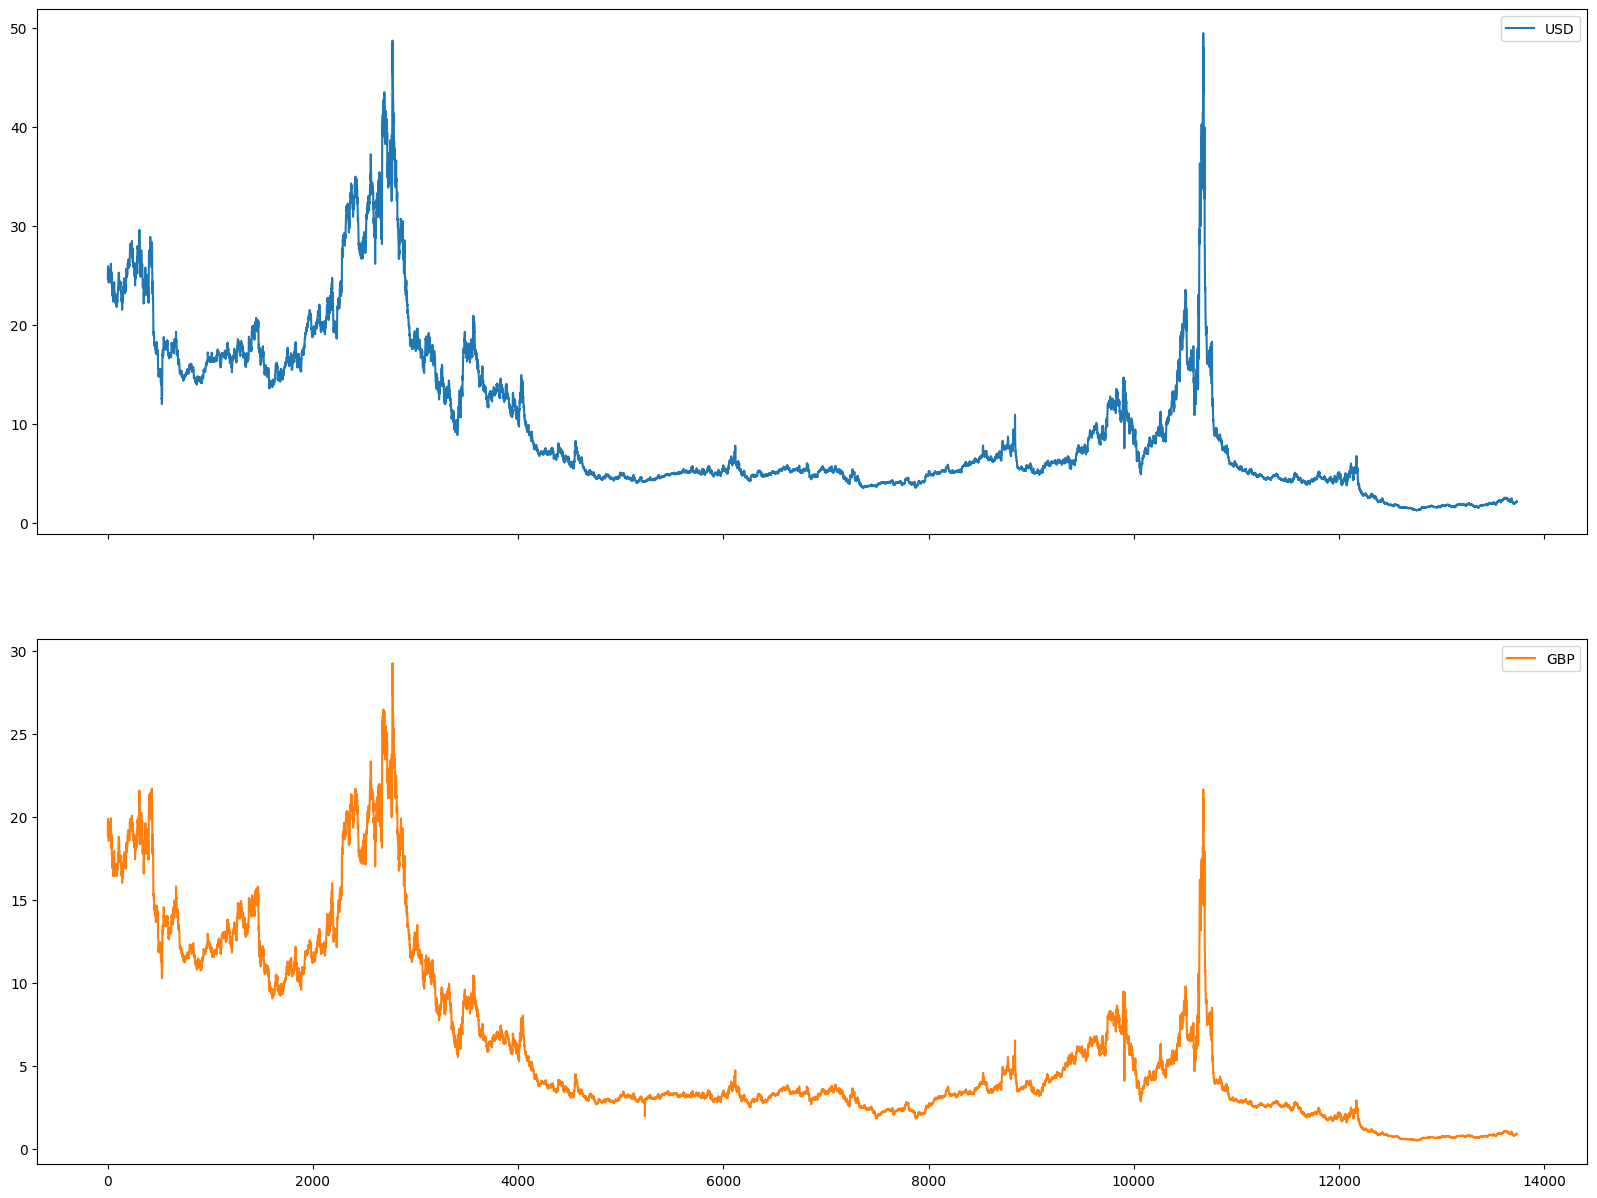

In [12]:
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(20, 15))
plt.show()

Date     object
USD     float64
GBP     float64
dtype: object

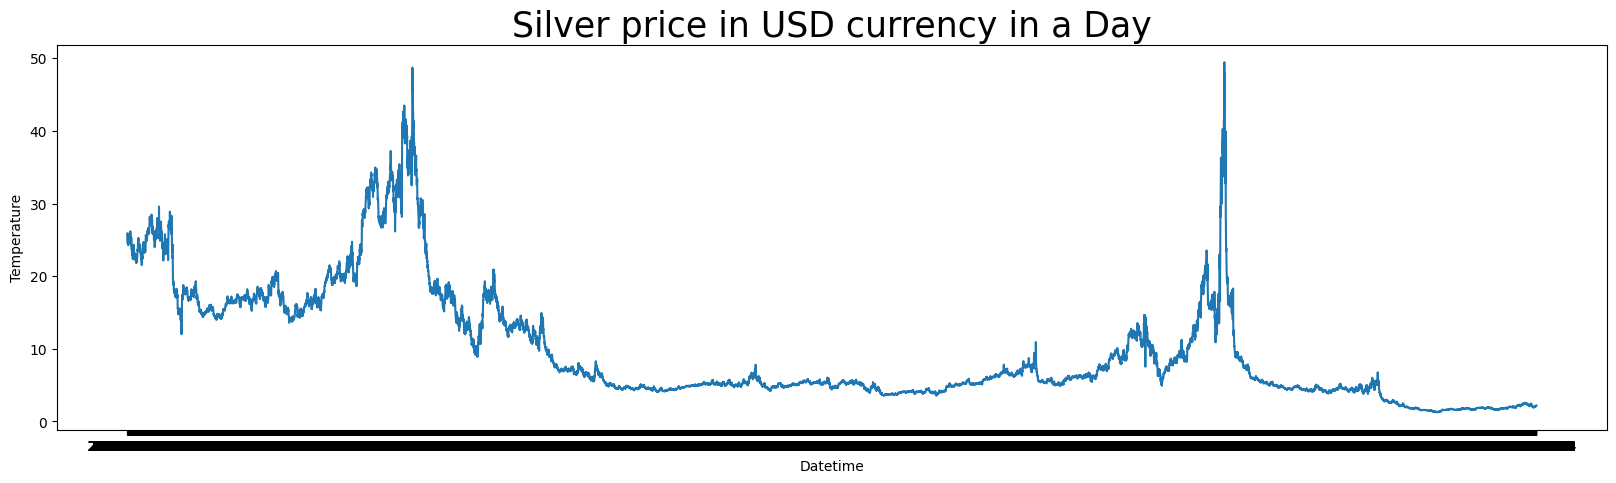

In [13]:
dates = df['Date'].values
usd = df['USD'].values

dates = np.array(dates)
usd = np.array(usd)

plt.figure(figsize=(20,5))
plt.plot(dates, usd)

plt.title('Silver price in USD currency in a Day', fontsize = 25)
plt.xlabel('Datetime', fontsize = 10)
plt.ylabel('Temperature', fontsize = 10)

df.dtypes

<ipython-input-14-2718f49b394d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


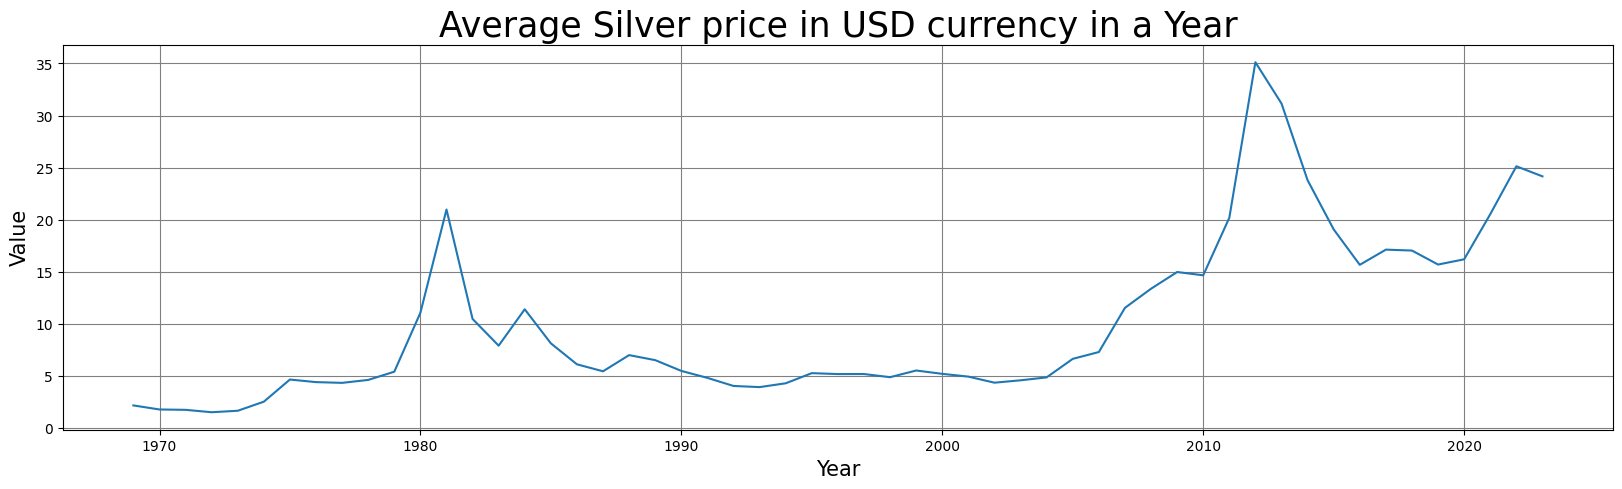

In [14]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

data_by_month = df.resample('A').mean()

time = data_by_month.index.values
test = data_by_month['USD'].values

plt.figure(figsize=(20,5))
plt.plot(time, test)
plt.title('Average Silver price in USD currency in a Year', fontsize = 25)
plt.ylabel('Value', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.grid(color='grey')

In [15]:
usd = np.array(df['USD'])
usd = usd.reshape(-1, 1)

scaler = MinMaxScaler()
usd = scaler.fit_transform(usd)

In [16]:
usd_train, usd_valid, dates_train, dates_valid = train_test_split(usd, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [20]:
train_set = windowed_dataset(usd_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(usd_valid, window_size=64, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 1]),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [21]:
threshold_mae = (usd.max() - usd.min()) * 10/100
print(threshold_mae)

0.1


In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print("\nMAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [25]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=800, validation_data = val_set, callbacks=[callbacks])

Epoch 1/800
55/55 [==============================] - 6s 58ms/step - loss: 0.0100 - mae: 0.1065 - val_loss: 0.0065 - val_mae: 0.1108
Epoch 2/800
55/55 [==============================] - 4s 71ms/step - loss: 0.0100 - mae: 0.1065 - val_loss: 0.0065 - val_mae: 0.1104
Epoch 3/800
55/55 [==============================] - 2s 40ms/step - loss: 0.0099 - mae: 0.1062 - val_loss: 0.0065 - val_mae: 0.1101
Epoch 4/800
55/55 [==============================] - 3s 46ms/step - loss: 0.0099 - mae: 0.1061 - val_loss: 0.0064 - val_mae: 0.1098
Epoch 5/800
55/55 [==============================] - 6s 103ms/step - loss: 0.0098 - mae: 0.1057 - val_loss: 0.0064 - val_mae: 0.1095
Epoch 6/800
55/55 [==============================] - 3s 49ms/step - loss: 0.0100 - mae: 0.1059 - val_loss: 0.0064 - val_mae: 0.1093
Epoch 7/800
55/55 [==============================] - 3s 44ms/step - loss: 0.0099 - mae: 0.1057 - val_loss: 0.0064 - val_mae: 0.1092
Epoch 8/800
55/55 [==============================] - 2s 40ms/step - loss: 0

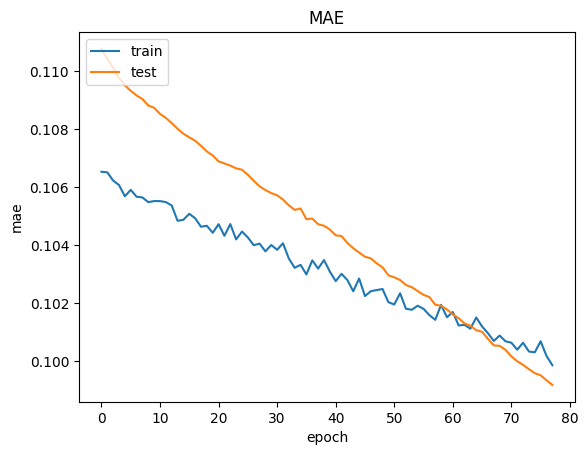

In [26]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

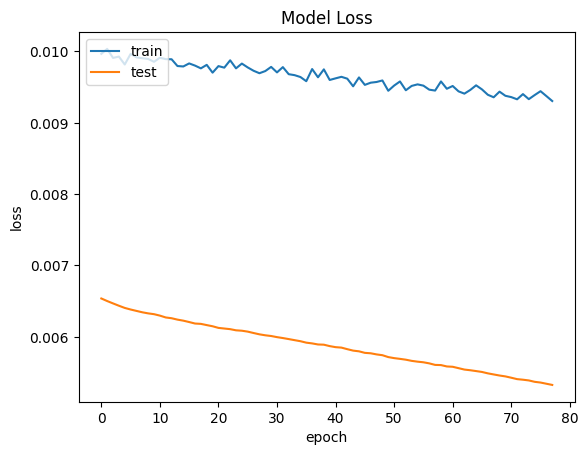

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()